# Getting Started with AuctionGym
## Effects of Competition in Second-Price Auctions

AuctionGym has several configuration options that detail the type of auction, how bidders behave, and how confounded the contextual information is that bidders observe. To avoid clutter, we define these in configuration files.
For the purposes of this introductory notebook, we will ignore some aspects such as repeated runs.

We parse an existing file, detailing a second-price auction with truthful oracle bidders.
We will look into the effects of increased competition on the auctioneer's revenue, social welfare and surplus.
For this, we repeat simulated experiments with a single changed parameter over runs: 'num_participants_per_round'.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from main import parse_config, instantiate_agents, instantiate_auction
from tqdm.notebook import tqdm

In [2]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values,\
num_runs, max_slots, embedding_size, embedding_var,\
obs_embedding_size = parse_config('../config/SP_Oracle.json')

In [3]:
def run_repeated_auctions(num_participants_per_round):
    # Placeholders for output
    auction_revenue = []
    social_welfare = []
    social_surplus = []
    
    # Set the environmental parameter
    config['num_participants_per_round'] = num_participants_per_round
    
    # Instantiate Agent and Auction objects
    agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)

    # Instantiate Auction object
    auction, num_iter, rounds_per_iter, output_dir =\
        instantiate_auction(rng,
                            config,
                            agents2items,
                            agents2item_values,
                            agents,
                            max_slots,
                            embedding_size,
                            embedding_var,
                            obs_embedding_size)

    # Run repeated auctions
    # This logic is encoded in the `simulation_run()` method in main.py
    for i in tqdm(range(num_iter)):

        # Simulate impression opportunities
        for _ in range(rounds_per_iter):
            auction.simulate_opportunity()

        # Log 'Gross utility' or welfare
        social_welfare.append(sum([agent.gross_utility for agent in auction.agents]))

        # Log 'Net utility' or surplus
        social_surplus.append(sum([agent.net_utility for agent in auction.agents]))
        
        # Update agents (does nothing in this example, as we have truthful oracles)
        # Clear running metrics
        for agent_id, agent in enumerate(auction.agents):
            agent.update(iteration=i)
            agent.clear_utility()
            agent.clear_logs()

        # Log revenue
        auction_revenue.append(auction.revenue)
        auction.clear_revenue()
        
    # Rescale metrics per auction round
    auction_revenue = np.array(auction_revenue) / rounds_per_iter
    social_welfare = np.array(social_welfare) / rounds_per_iter
    social_surplus = np.array(social_surplus) / rounds_per_iter
    
    return auction_revenue, social_welfare, social_surplus

In [4]:
num_participants_2_metrics = {
    num_participants_per_round: run_repeated_auctions(num_participants_per_round=num_participants_per_round)
    for num_participants_per_round in range(2,7)
}

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

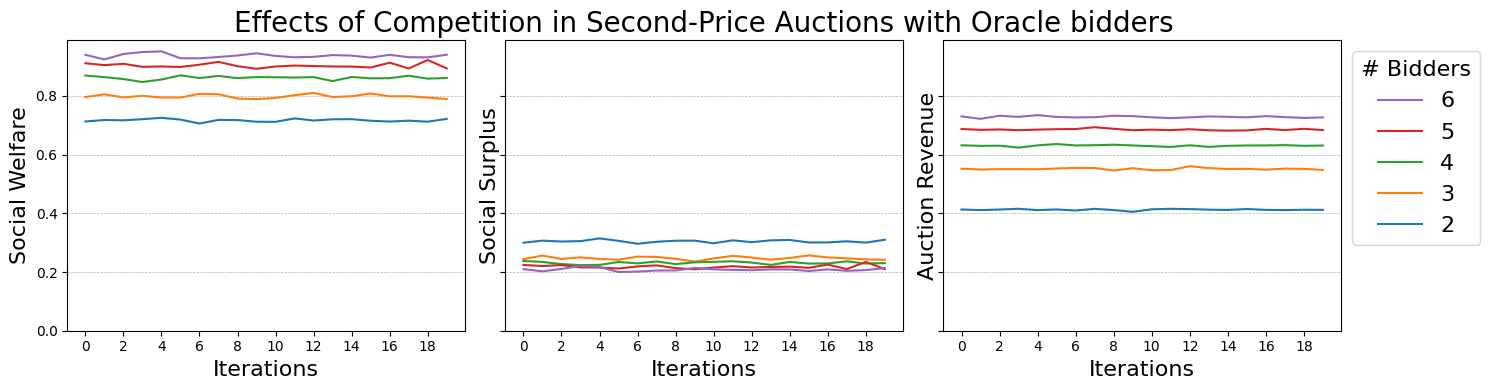

In [5]:
fontsize=16
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(15,4))

for num_participants_per_round, (revenue, welfare, surplus) in num_participants_2_metrics.items():    
    axes[0].plot(welfare, label=f'{num_participants_per_round}')
    axes[1].plot(surplus, label=f'{num_participants_per_round}')
    axes[2].plot(revenue, label=f'{num_participants_per_round}')


axes[1].set_title('Effects of Competition in Second-Price Auctions with Oracle bidders', fontsize=fontsize+4)

for i in range(3):
    axes[i].set_xlabel('Iterations', fontsize=fontsize)
    axes[i].set_xticks(list(range(0,len(revenue),2)))
    axes[i].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

axes[0].set_ylim(0.0, None)

    
axes[0].set_ylabel('Social Welfare', fontsize=fontsize)
axes[1].set_ylabel('Social Surplus', fontsize=fontsize)
axes[2].set_ylabel('Auction Revenue', fontsize=fontsize)

handles, labels = axes[0].get_legend_handles_labels()
legend = axes[2].legend(reversed(handles),
                   reversed(labels),
                   loc='upper left',
                   bbox_to_anchor=(1.0, 1.0),
                   fontsize=fontsize)
legend.set_title('# Bidders', prop={'size': fontsize})
fig.tight_layout()

plt.show()

The leftmost plot shows social welfare (the sum of generated welfare over all participants in the auction).
As we increase the number of participants in every auction round, the probability that the advertiser with the highest value ad is participating increases, and so does expected welfare.

The middle plot shows social surplus.
As the number of participants in the auction increases, there will be stronger competition, which drives up the second price. As a result, the surplus that bidders attain decreases.

The rightmost plot shows revenue for the auctioneer.
Because of the combined effect of (1) increasing welfare and (2) decreasing surplus, we see significant increases in auction revenue as the number of participants per auction round increases.